In [4]:
import circularPitchSpace as cps
import numpy as np

chroma = np.ones(shape=(2,12))
cps.getPitchClassEnergy(chroma)

TypeError: tuple indices must be integers or slices, not str

In [17]:
import pandas as pd
import numpy as np
import dataloader
import circularPitchSpace as cps
import matplotlib.pyplot as plt
import utils
import madmom
import librosa
import scipy

activations_processor = madmom.features.beats.RNNBeatProcessor()
beat_processor = madmom.features.beats.BeatTrackingProcessor(fps=100)
subset = 'majmin'
path = "/home/max/ET-TI/Masterarbeit/datasets/beatles/"
dataset = dataloader.BeatlesDataset(path,'madmom',False)

# let it be chroma
t,chroma,ref_interval,ref_labels = dataset[103]
audiopath = dataset.getFilepaths(103)[0]
beats = beat_processor(activations_processor(audiopath))

/home/max/.local/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


$F^{maj7}$


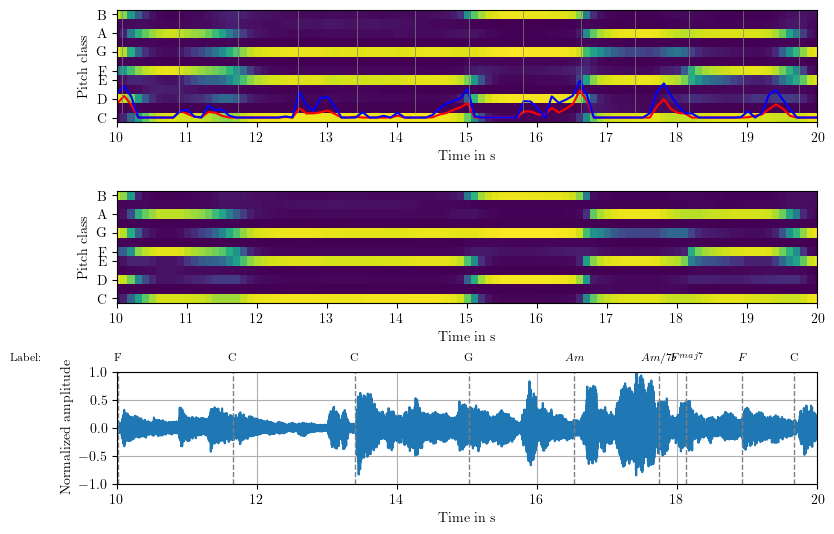

In [31]:

def movingAverage(data,N=5):
    mean = np.zeros_like(data)
    i = N
    mean[:i] = np.sum(data[:i]/i)
    while i < data.shape[0]:
        # Calculate the average of current window
        mean[i] = np.sum(data[i-N:i])/N
        i += 1
    return mean

def modifiedKullbackLeiblerDivergence(chroma,changes='all'):
    if chroma.shape[0] < 2 or chroma.shape[1] != 12:
        raise ValueError("invalid chroma vector")
    X_0 = chroma
    # delay array by one sample
    X_1 = np.zeros_like(X_0)
    X_1[1:,:] = X_0[:-1,:]
    # calculate modified kullback-leibler-divergence
    # only detect positive energy changes
    if changes == 'neg':
        energetic_changes = np.abs(X_1)/(np.abs(X_0)+np.finfo(float).eps)
        energetic_changes[energetic_changes <1] = 0
    # neglect negative energy changes
    elif changes == 'pos':
        energetic_changes = np.abs(X_0)/(np.abs(X_1)+np.finfo(float).eps)
        energetic_changes[energetic_changes <1] = 0
    else:
        energetic_changes = np.abs(X_0)/(np.abs(X_1)+np.finfo(float).eps)
    dkl = np.sum(np.log(1+energetic_changes),axis=1)
    # ignore first sample
    dkl[0] = 0.0
    dkl = dkl/np.max(dkl)
    dkl = dkl - movingAverage(dkl,10)
    dkl[dkl<0] = 0.0   
    return dkl

def chromaEnhancing(chroma,median=True):
    # use non-local filtering
    temp = chroma.T
    chroma_enhanced = np.minimum(temp,
                            librosa.decompose.nn_filter(temp,
                                                        aggregate=np.average,
                                                        metric='cosine'))
    # apply horizontal median filter
    if median:
        chroma_enhanced = scipy.ndimage.median_filter(chroma_enhanced, size=(1, 5)).T
        return chroma_enhanced
    else:
        return chroma_enhanced.T
    


fig,ax = plt.subplots(3,1,figsize=((8.27,11.69/2)))
fig.tight_layout(pad=3)

chroma_enhanced = chromaEnhancing(chroma)
time=(10,20)
utils.plotChroma(ax[0],chroma,time)
ax[0].plot(t,10*modifiedKullbackLeiblerDivergence(chroma,changes='all'),'r')
ax[0].plot(t,10*modifiedKullbackLeiblerDivergence(chroma,changes='pos'),'b')
ax[0].vlines(beats,0.5*np.ones_like(beats),11.5*np.ones_like(beats),colors='grey',linewidth=0.5)
utils.plotChroma(ax[1],chroma_enhanced,time)
utils.plotAudioWaveform(ax[2],audiopath,time)
utils.plotAnnotations(ax[2],ref_interval,ref_labels,time)

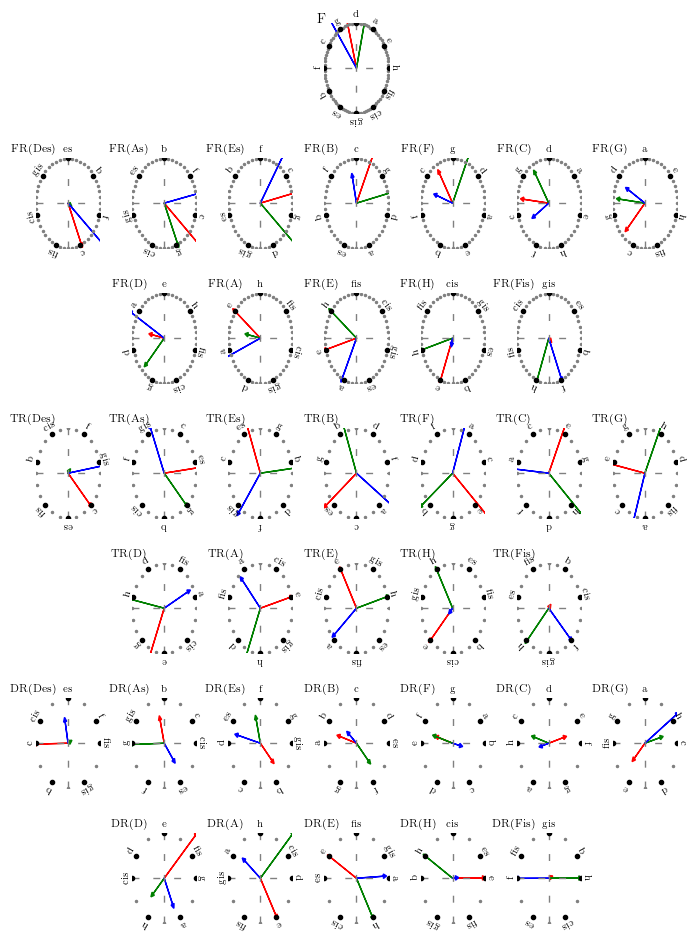

In [8]:

rho_F,rho_FR,rho_TR,rho_DR = cps.transformChroma(chroma)
timesteps = [(1,'r'),(2.5,'g'),(6.5,'b')]
fig_cps,axes_list = cps.plotPitchSpace()
for item in timesteps:
    t_index,color=item
    index = int(t_index*10)
    cps.plotFeatures(axes_list,rho_F[index],rho_FR[index],rho_TR[index],rho_DR[index],color=color)
